In [ ]:

import os
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:

# Paths
RAW_DATA_DIR = '../data/raw'
PROCESSED_DATA_DIR = '../data/processed'

# Classes
CLASSES = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"Train: {TRAIN_RATIO*100}% | Val: {VAL_RATIO*100}% | Test: {TEST_RATIO*100}%")



Train: 70.0% | Val: 15.0% | Test: 15.0%


In [ ]:

def create_split_directories():
    """Create train/val/test directories"""
    splits = ['train', 'val', 'test']
    
    for split in splits:
        for cls in CLASSES:
            path = os.path.join(PROCESSED_DATA_DIR, split, cls)
            os.makedirs(path, exist_ok=True)
            print(f"✅ Created: {path}")

create_split_directories()


✅ Created: ../data/processed\train\COVID
✅ Created: ../data/processed\train\Normal
✅ Created: ../data/processed\train\Lung_Opacity
✅ Created: ../data/processed\train\Viral Pneumonia
✅ Created: ../data/processed\val\COVID
✅ Created: ../data/processed\val\Normal
✅ Created: ../data/processed\val\Lung_Opacity
✅ Created: ../data/processed\val\Viral Pneumonia
✅ Created: ../data/processed\test\COVID
✅ Created: ../data/processed\test\Normal
✅ Created: ../data/processed\test\Lung_Opacity
✅ Created: ../data/processed\test\Viral Pneumonia


In [ ]:

def split_dataset():
    """
    Split dataset into train/val/test and copy files
    Maintains class distribution in each split
    """
    
    split_info = {
        'class': [],
        'train': [],
        'val': [],
        'test': [],
        'total': []
    }
    
    print("\n" + "="*70)
    print("SPLITTING DATASET")
    print("="*70)
    
    for cls in CLASSES:
        print(f"\nProcessing class: {cls}")
        
        # Get all image paths
        img_dir = os.path.join(RAW_DATA_DIR, cls, 'images')
        all_images = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        
        total_images = len(all_images)
        print(f"  Total images: {total_images}")
        
        # First split: train + (val+test)
        train_images, temp_images = train_test_split(
            all_images,
            test_size=(VAL_RATIO + TEST_RATIO),
            random_state=RANDOM_SEED
        )
        
        # Second split: val + test
        val_images, test_images = train_test_split(
            temp_images,
            test_size=TEST_RATIO/(VAL_RATIO + TEST_RATIO),
            random_state=RANDOM_SEED
        )
        
        print(f"  Train: {len(train_images)} | Val: {len(val_images)} | Test: {len(test_images)}")
        
        # Copy files
        splits_data = {
            'train': train_images,
            'val': val_images,
            'test': test_images
        }
        
        for split_name, images in splits_data.items():
            src_dir = img_dir
            dst_dir = os.path.join(PROCESSED_DATA_DIR, split_name, cls)
            
            for img_name in tqdm(images, desc=f"  Copying {split_name}", leave=False):
                src_path = os.path.join(src_dir, img_name)
                dst_path = os.path.join(dst_dir, img_name)
                shutil.copy2(src_path, dst_path)
        
        # Store info
        split_info['class'].append(cls)
        split_info['train'].append(len(train_images))
        split_info['val'].append(len(val_images))
        split_info['test'].append(len(test_images))
        split_info['total'].append(total_images)
    
    return pd.DataFrame(split_info)

# Execute split
split_df = split_dataset()

print("\n" + "="*70)
print("SPLIT SUMMARY")
print("="*70)
print(split_df.to_string(index=False))
print("="*70)



SPLITTING DATASET

Processing class: COVID
  Total images: 3616
  Train: 2531 | Val: 542 | Test: 543



Processing class: Normal
  Total images: 10192
  Train: 7134 | Val: 1529 | Test: 1529



Processing class: Lung_Opacity
  Total images: 6012
  Train: 4208 | Val: 902 | Test: 902



Processing class: Viral Pneumonia
  Total images: 1345
  Train: 941 | Val: 202 | Test: 202



SPLIT SUMMARY
          class  train  val  test  total
          COVID   2531  542   543   3616
         Normal   7134 1529  1529  10192
   Lung_Opacity   4208  902   902   6012
Viral Pneumonia    941  202   202   1345


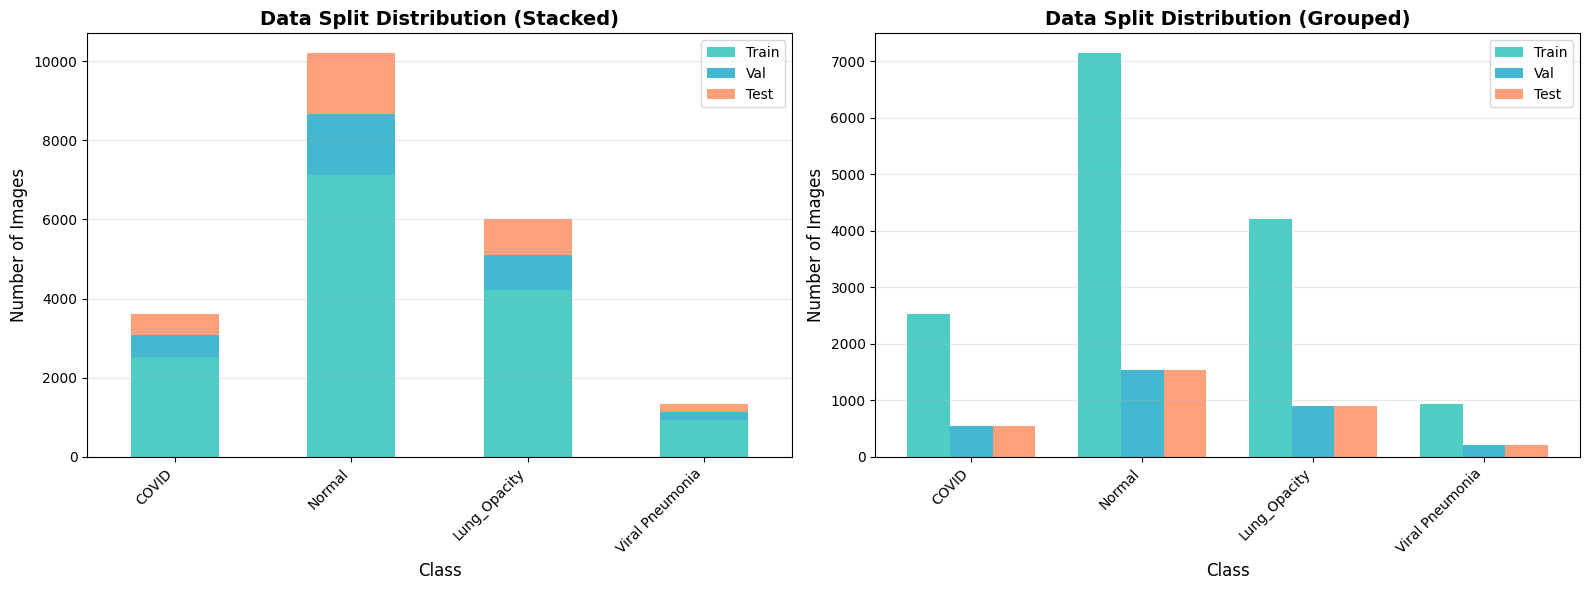

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Stacked bar chart
split_df.plot(x='class', y=['train', 'val', 'test'], kind='bar', stacked=True, 
              ax=axes[0], color=['#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0].set_title('Data Split Distribution (Stacked)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].legend(['Train', 'Val', 'Test'])
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Plot 2: Grouped bar chart
x = np.arange(len(CLASSES))
width = 0.25

axes[1].bar(x - width, split_df['train'], width, label='Train', color='#4ECDC4')
axes[1].bar(x, split_df['val'], width, label='Val', color='#45B7D1')
axes[1].bar(x + width, split_df['test'], width, label='Test', color='#FFA07A')

axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].set_title('Data Split Distribution (Grouped)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(CLASSES, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/data_split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:

# Cell 6: Calculate and display percentages
print("\nSplit Percentages by Class:")
print("="*70)

for idx, row in split_df.iterrows():
    cls = row['class']
    total = row['total']
    train_pct = (row['train'] / total) * 100
    val_pct = (row['val'] / total) * 100
    test_pct = (row['test'] / total) * 100
    
    print(f"{cls:20} | Train: {train_pct:.1f}% | Val: {val_pct:.1f}% | Test: {test_pct:.1f}%")

print("="*70)




Split Percentages by Class:
COVID                | Train: 70.0% | Val: 15.0% | Test: 15.0%
Normal               | Train: 70.0% | Val: 15.0% | Test: 15.0%
Lung_Opacity         | Train: 70.0% | Val: 15.0% | Test: 15.0%
Viral Pneumonia      | Train: 70.0% | Val: 15.0% | Test: 15.0%


In [7]:
# Cell 7: Save split information to CSV
split_df.to_csv('../results/metrics/data_split_info.csv', index=False)
print("\n✅ Split information saved to '../results/metrics/data_split_info.csv'")



✅ Split information saved to '../results/metrics/data_split_info.csv'


In [8]:

# Cell 8: Verify splits
print("\nVerifying splits...")
for split in ['train', 'val', 'test']:
    print(f"\n{split.upper()}:")
    total_split = 0
    for cls in CLASSES:
        path = os.path.join(PROCESSED_DATA_DIR, split, cls)
        count = len(os.listdir(path))
        total_split += count
        print(f"  {cls:20} : {count:5} images")
    print(f"  {'TOTAL':20} : {total_split:5} images")

print("\n✅ Data split complete!")



Verifying splits...

TRAIN:
  COVID                :  2531 images
  Normal               :  7134 images
  Lung_Opacity         :  4208 images
  Viral Pneumonia      :   941 images
  TOTAL                : 14814 images

VAL:
  COVID                :   542 images
  Normal               :  1529 images
  Lung_Opacity         :   902 images
  Viral Pneumonia      :   202 images
  TOTAL                :  3175 images

TEST:
  COVID                :   543 images
  Normal               :  1529 images
  Lung_Opacity         :   902 images
  Viral Pneumonia      :   202 images
  TOTAL                :  3176 images

✅ Data split complete!
